In [42]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(42)

In [43]:
def create_xor_dataset(n_samples=1000, noise=0.05):
    np.random.seed(0)
    X = np.random.rand(n_samples, 2) * 2 - 1
    y = (X[:, 0] * X[:, 1] > 0).astype(int)
    y[y == 0] = 0
    y = y.astype(float)
    X += np.random.normal(scale=noise, size=X.shape)
    return X, y

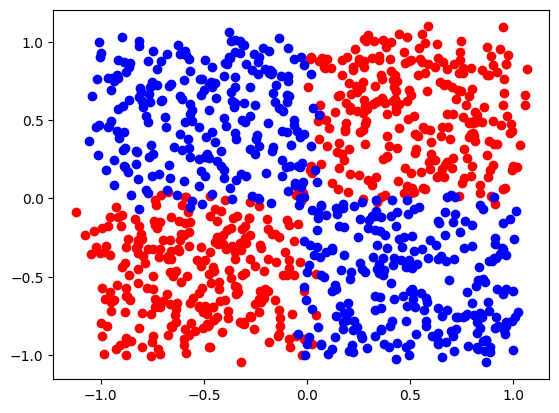

In [44]:
train_x, train_y = create_xor_dataset(1000)

plt.scatter(train_x[train_y == 1, 0], train_x[train_y == 1, 1], c='r', label='1')
plt.scatter(train_x[train_y == 0, 0], train_x[train_y == 0, 1], c='b', label='-1')

In [45]:
test_x, test_y = create_xor_dataset(100, 0.1)

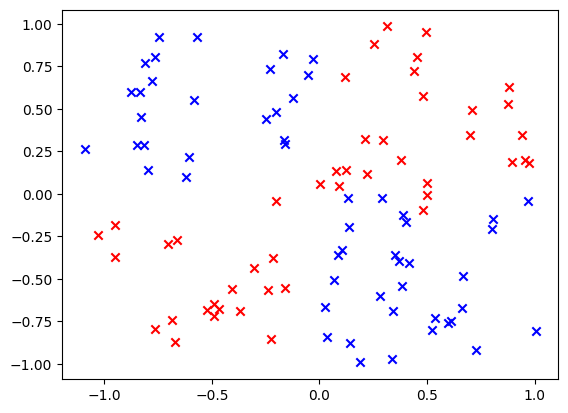

In [46]:
plt.scatter(test_x[test_y == 1, 0], test_x[test_y == 1, 1], c='r', label='1', marker='x')
plt.scatter(test_x[test_y == 0, 0], test_x[test_y == 0, 1], c='b', label='-1', marker='x')

In [47]:
def reset_ctx(func):
    def wrapper(self, *args, **kwargs):
        res = func(self, *args, **kwargs)
        self.ctx = None
        return res
    return wrapper


class Module:
    ctx = None
    is_init = False

    def __call__(self, *args, **kwargs):
        if not self.is_init:
            self.init(*args, **kwargs)
            self.is_init = True
        self.ctx = self.cache_ctx(*args, **kwargs)
        return self.forward(*args, **kwargs)

    def init(self, *args, **kwargs):
        pass

    def apply(self, *args, **kwargs):
        pass

    def reset_grad(self, *args, **kwargs):
        pass

    def cache_ctx(self, *args, **kwargs):
        pass


class Sequential(Module):
    def __init__(self, *args):
        self.modules = args

    def forward(self, x, **kwargs):
        for m in self.modules:
            x = m(x)
        return x

    def backward(self, d_out):
        for m in reversed(self.modules):
            d_out = m.backward(d_out)
        return d_out

    def apply(self, lr, f):
        for m in self.modules:
            m.apply(lr, f)
            m.reset_grad()

    def reset_grad(self):
        for m in self.modules:
            m.reset_grad()
    
    def __getitem__(self, idx):
        return self.modules[idx]


In [48]:
def zero_init(shape):
    return np.zeros(shape)


def normal_init(shape):
    return np.random.normal(size=shape)


def xavier_init(shape):
    return np.random.normal(scale=1/np.sqrt(shape[0]), size=shape)


def he_init(shape):
    return np.random.normal(scale=2/shape[0], size=shape)

In [49]:
class ReLU(Module):
    def __init__(self):
        self.is_init = True

    def forward(self, x, *args, **kwargs):
        return np.maximum(0, x)
    
    def cache_ctx(self, x, **kwargs):
        return x

    @reset_ctx
    def backward(self, c_out):
        x_cached = self.ctx
        d_x = c_out * (x_cached > 0)
        return d_x


class Linear(Module):
    def __init__(self, dim, use_bias=True, kernel_init=xavier_init, bias_init=zero_init):
        self.dim = dim
        self.use_bias = use_bias
        self.W = None
        self.b = None
        self.kernel_init = kernel_init
        self.bias_init = bias_init

    def init(self, x, **kwargs):
        # self.W = np.random.normal(0, 0.01, (x.shape[-1], self.dim))
        W_shape = (x.shape[-1], self.dim)
        self.W = self.kernel_init(W_shape)
        if self.use_bias:
            # self.b = np.zeros((1, self.dim))
            b_shape = (1, self.dim)
            self.b = self.bias_init(b_shape)

    def forward(self, x, **kwargs):
        return np.dot(x, self.W) + self.b

    def cache_ctx(self, x, **kwargs):
        return x

    @reset_ctx
    def backward(self, d_out):
        x_cached = self.ctx
        m = x_cached.shape[0]
        self.d_w = np.dot(x_cached.T, d_out) / m
        if self.use_bias:
            self.d_b = np.sum(d_out, axis=0, keepdims=True) / m
        d_x = np.dot(d_out, self.W.T)
        return d_x
    
    def apply(self, lr, f):
        # if f is gradient_descent:
        if f is gradient_descent:
            self.W = f(self.W, self.d_w, lr)
            if self.use_bias:
                self.b = f(self.b, self.d_b, lr)
        
        elif f is gradient_descent_with_momentum or f is nesterov_grad_descent:
            if not hasattr(self, 'v_w'):
                self.v_w = 0
            v_w = self.v_w
            self.W, self.v_w = f(self.W, self.d_w, lr, 0.9, v_w)
            if self.use_bias:
                if not hasattr(self, 'v_b'):
                    self.v_b = 0
                v_b = self.v_b
                self.b, self.v_b = f(self.b, self.d_b, lr, 0.9, v_b)
            
        self.reset_grad()
        
    def reset_grad(self):
        self.d_w = None
        self.d_b = None


def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))


class Sigmoid(Module):
    def __init__(self):
        self.is_init = True

    def forward(self, x, *args, **kwargs):
        return sigmoid(x)

    def cache_ctx(self, x, **kwargs):
        return x
    
    @reset_ctx
    def backward(self, c_out):
        x_cached = self.ctx
        s = sigmoid(x_cached)
        d_x = (s * (1 - s)) * c_out
        return d_x
    

def tanh(x):
    x = np.clip(x, -500, 500)
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


class Tanh(Module):
    def __init__(self):
        self.is_init = True

    def forward(self, x, *args, **kwargs):
        return tanh(x)

    def cache_ctx(self, x, **kwargs):
        return x
    
    @reset_ctx
    def backward(self, c_out):
        x_cached = self.ctx
        d_x = (1 - tanh(x_cached) ** 2) * c_out
        return d_x


class BCEFromLogit(Module):
    def __init__(self):
        self.is_init = True
    
    def forward(self, pred, target):
        target = target.reshape(-1, 1)
        pred = sigmoid(pred)
        return -np.mean(target * np.log(pred) + (1 - target) * np.log(1 - pred))
    
    def cache_ctx(self, x, y, **kwargs):
        return x, y  
    
    @reset_ctx
    def backward(self):
        cached_pred, cached_target = self.ctx
        cached_target = cached_target.reshape(-1, 1)
        d_x = sigmoid(cached_pred) - cached_target
        return d_x


def gradient_descent(param, grad, lr):
    return param - (lr * grad)


def gradient_descent_with_momentum(param, grad, lr, momentum, v):
    v = momentum * v - lr * grad
    return param + v, v


def nesterov_grad_descent(param, grad, lr, momentum, v):
    v = momentum * v - lr * grad
    return param + momentum * v - lr * grad, v

In [50]:
module = Linear(1)
loss_fn = BCEFromLogit()

epochs = 10000
lr = 0.0001
batch_size = 32
n_batches = train_x.shape[0] // batch_size

idxs = np.arange(train_x.shape[0])

loss_log = []

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = train_x[batch_idxs]
        y_batch = train_y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        module.backward(loss_fn.backward())
        module.apply(lr, gradient_descent)
        module.reset_grad()

100%|██████████| 10000/10000 [00:24<00:00, 411.86it/s]


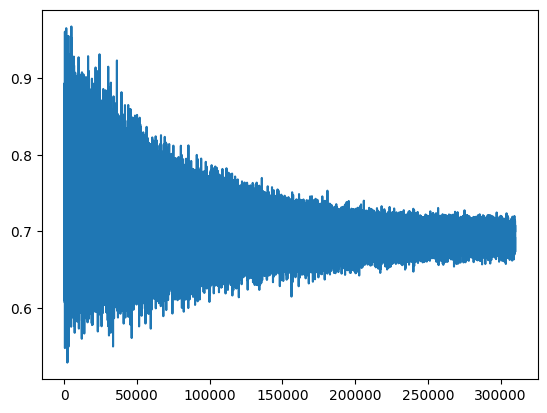

In [51]:
plt.plot(loss_log)

Accuracy: 0.42


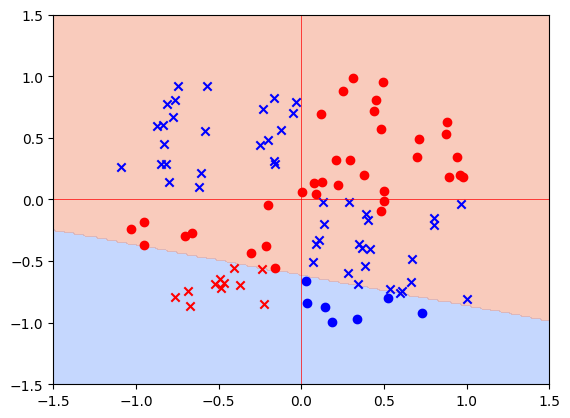

In [52]:
y_pred = module(test_x)
y_pred = sigmoid(y_pred)[..., 0]

y_pred = (y_pred > 0.5).astype(int)

acc = np.mean(y_pred == test_y)
print(f'Accuracy: {acc}')


# visualize y_hat
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
Z = module(np.c_[X.ravel(), Y.ravel()])
Z = sigmoid(Z).reshape(X.shape)
Z = (Z > 0.5).astype(int)

plt.contourf(X, Y, Z, levels=1, alpha=0.5, vmin=0, vmax=1, cmap='coolwarm')

# color by test_y
# o for correct, x for incorrect
is_correct = y_pred == test_y
plt.scatter(test_x[is_correct & (test_y == 1), 0], test_x[is_correct & (test_y == 1), 1], c='r', label='1', marker='o')
plt.scatter(test_x[is_correct & (test_y == 0), 0], test_x[is_correct & (test_y == 0), 1], c='b', label='-1', marker='o')
plt.scatter(test_x[~is_correct & (test_y == 1), 0], test_x[~is_correct & (test_y == 1), 1], c='r', label='1', marker='x')
plt.scatter(test_x[~is_correct & (test_y == 0), 0], test_x[~is_correct & (test_y == 0), 1], c='b', label='-1', marker='x')


# lines at 0, 0 (v, h)
plt.axhline(0, color='red', lw=0.5)
plt.axvline(0, color='red', lw=0.5)

plt.show()


In [53]:
module = Sequential(
    Linear(4),
    ReLU(),
    Linear(1)
)
loss_fn = BCEFromLogit()

epochs = 10000
lr = 0.0001
batch_size = 16
n_batches = train_x.shape[0] // batch_size

idxs = np.arange(train_x.shape[0])

loss_log = []

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = train_x[batch_idxs]
        y_batch = train_y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        module.backward(loss_fn.backward())
        module.apply(lr, gradient_descent)
        module.reset_grad()

100%|██████████| 10000/10000 [01:09<00:00, 143.51it/s]


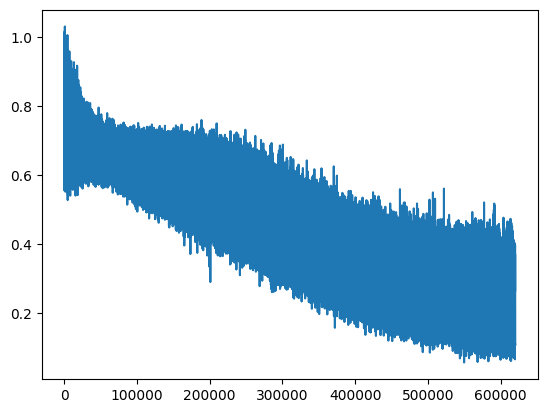

In [54]:
plt.plot(loss_log)

Accuracy: 0.92


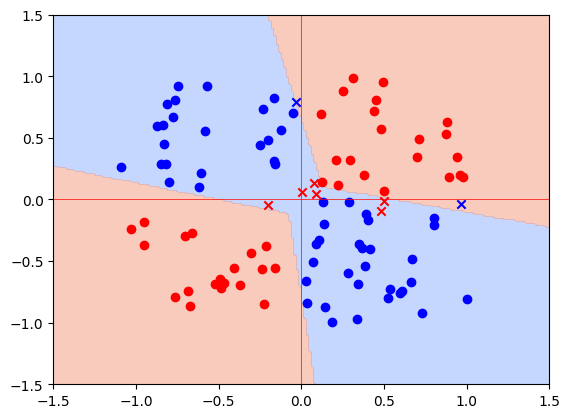

In [55]:
y_pred = module(test_x)
y_pred = sigmoid(y_pred)[..., 0]

y_pred = (y_pred > 0.5).astype(int)

acc = np.mean(y_pred == test_y)
print(f'Accuracy: {acc}')


# visualize y_hat
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
Z = module(np.c_[X.ravel(), Y.ravel()])
Z = sigmoid(Z).reshape(X.shape)
Z = (Z > 0.5).astype(int)

plt.contourf(X, Y, Z, levels=1, alpha=0.5, vmin=0, vmax=1, cmap='coolwarm')

# color by test_y
# o for correct, x for incorrect
is_correct = y_pred == test_y
plt.scatter(test_x[is_correct & (test_y == 1), 0], test_x[is_correct & (test_y == 1), 1], c='r', label='1', marker='o')
plt.scatter(test_x[is_correct & (test_y == 0), 0], test_x[is_correct & (test_y == 0), 1], c='b', label='-1', marker='o')
plt.scatter(test_x[~is_correct & (test_y == 1), 0], test_x[~is_correct & (test_y == 1), 1], c='r', label='1', marker='x')
plt.scatter(test_x[~is_correct & (test_y == 0), 0], test_x[~is_correct & (test_y == 0), 1], c='b', label='-1', marker='x')


# lines at 0, 0 (v, h)
plt.axhline(0, color='red', lw=0.5)
plt.axvline(0, color='red', lw=0.5)

plt.show()

In [56]:
module = Sequential(
    Linear(4),
    ReLU(),
    Linear(1)
)
loss_fn = BCEFromLogit()

epochs = 100000
lr = 0.0001
batch_size = 128
n_batches = train_x.shape[0] // batch_size

idxs = np.arange(train_x.shape[0])

loss_log = []

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = train_x[batch_idxs]
        y_batch = train_y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        module.backward(loss_fn.backward())
        module.apply(lr, gradient_descent_with_momentum)
        module.reset_grad()

100%|██████████| 100000/100000 [01:30<00:00, 1100.48it/s]


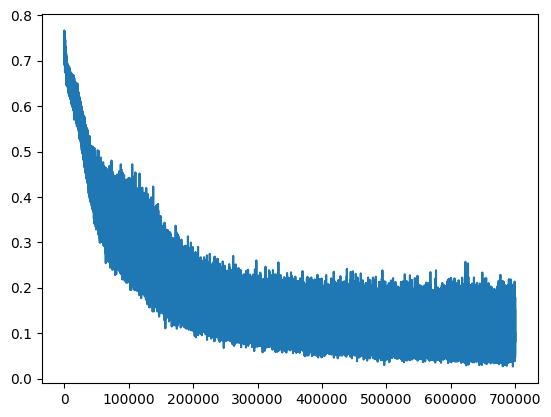

In [57]:
plt.plot(loss_log)

Accuracy: 0.94


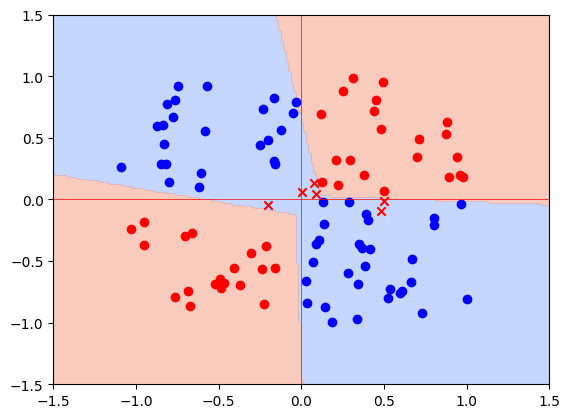

In [58]:
y_pred = module(test_x)
y_pred = sigmoid(y_pred)[..., 0]

y_pred = (y_pred > 0.5).astype(int)

acc = np.mean(y_pred == test_y)
print(f'Accuracy: {acc}')


# visualize y_hat
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
Z = module(np.c_[X.ravel(), Y.ravel()])
Z = sigmoid(Z).reshape(X.shape)
Z = (Z > 0.5).astype(int)

plt.contourf(X, Y, Z, levels=1, alpha=0.5, vmin=0, vmax=1, cmap='coolwarm')

# color by test_y
# o for correct, x for incorrect
is_correct = y_pred == test_y
plt.scatter(test_x[is_correct & (test_y == 1), 0], test_x[is_correct & (test_y == 1), 1], c='r', label='1', marker='o')
plt.scatter(test_x[is_correct & (test_y == 0), 0], test_x[is_correct & (test_y == 0), 1], c='b', label='-1', marker='o')
plt.scatter(test_x[~is_correct & (test_y == 1), 0], test_x[~is_correct & (test_y == 1), 1], c='r', label='1', marker='x')
plt.scatter(test_x[~is_correct & (test_y == 0), 0], test_x[~is_correct & (test_y == 0), 1], c='b', label='-1', marker='x')


# lines at 0, 0 (v, h)
plt.axhline(0, color='red', lw=0.5)
plt.axvline(0, color='red', lw=0.5)

plt.show()

In [59]:
module = Sequential(
    Linear(4),
    ReLU(),
    Linear(1)
)
loss_fn = BCEFromLogit()

epochs = 100000
lr = 0.0001
batch_size = 128
n_batches = train_x.shape[0] // batch_size

idxs = np.arange(train_x.shape[0])

loss_log = []

for epoch in tqdm(range(epochs)):
    for batch in range(n_batches):
        batch_idxs = np.random.choice(idxs, batch_size, replace=False)
        x_batch = train_x[batch_idxs]
        y_batch = train_y[batch_idxs]
        pred = module(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_log.append(loss)
        module.backward(loss_fn.backward())
        module.apply(lr, nesterov_grad_descent)
        module.reset_grad()

100%|██████████| 100000/100000 [01:35<00:00, 1042.66it/s]


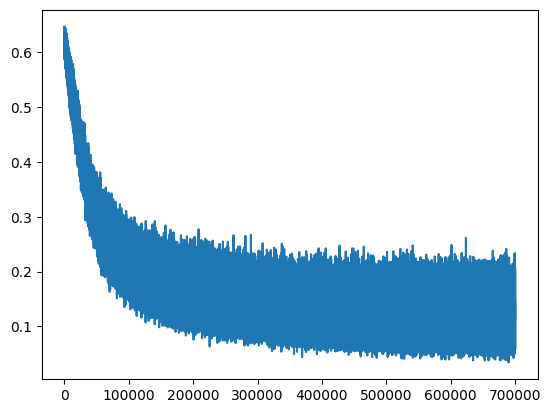

In [60]:
plt.plot(loss_log)

Accuracy: 0.98


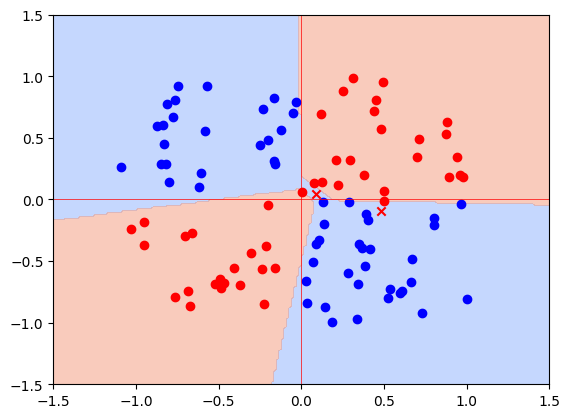

In [61]:
y_pred = module(test_x)
y_pred = sigmoid(y_pred)[..., 0]

y_pred = (y_pred > 0.5).astype(int)

acc = np.mean(y_pred == test_y)
print(f'Accuracy: {acc}')


# visualize y_hat
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
Z = module(np.c_[X.ravel(), Y.ravel()])
Z = sigmoid(Z).reshape(X.shape)
Z = (Z > 0.5).astype(int)

plt.contourf(X, Y, Z, levels=1, alpha=0.5, vmin=0, vmax=1, cmap='coolwarm')

# color by test_y
# o for correct, x for incorrect
is_correct = y_pred == test_y
plt.scatter(test_x[is_correct & (test_y == 1), 0], test_x[is_correct & (test_y == 1), 1], c='r', label='1', marker='o')
plt.scatter(test_x[is_correct & (test_y == 0), 0], test_x[is_correct & (test_y == 0), 1], c='b', label='-1', marker='o')
plt.scatter(test_x[~is_correct & (test_y == 1), 0], test_x[~is_correct & (test_y == 1), 1], c='r', label='1', marker='x')
plt.scatter(test_x[~is_correct & (test_y == 0), 0], test_x[~is_correct & (test_y == 0), 1], c='b', label='-1', marker='x')


# lines at 0, 0 (v, h)
plt.axhline(0, color='red', lw=0.5)
plt.axvline(0, color='red', lw=0.5)

plt.show()